In [1]:
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
import apex
from sklearn.model_selection import train_test_split

import datetime

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc

In [28]:
MAIN_DIR = 'C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/' # Directory where this .ipynb file sits

DATA_PATH = Path(MAIN_DIR + '/bert_data/') # Need to create directory beforehand
LABEL_PATH = Path(MAIN_DIR + '/bert_data/') # Need labels.csv (see https://github.com/kaushaltrivedi/fast-bert how to format)

AUG_DATA_PATH = Path(MAIN_DIR + '/bert_models/data_augmentation/') # Need to create directory beforehand
MODEL_PATH=Path(MAIN_DIR + '/bert_models/models/') # Need to create directory beforehand
LOG_PATH=Path(MAIN_DIR + '/bert_models/logs/') # Need to create directory beforehand
MODEL_PATH.mkdir(exist_ok=True)

model_state_dict = None

# BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/cased_L-12_H-768_A-12/')
BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/uncased_L-12_H-768_A-12/')
# BERT_PRETRAINED_PATH = Path('../../bert_fastai/pretrained-weights/uncased_L-24_H-1024_A-16/')
# FINETUNED_PATH = Path('../models/finetuned_model.bin')
FINETUNED_PATH = None
# model_state_dict = torch.load(FINETUNED_PATH)

LOG_PATH.mkdir(exist_ok=True)

OUTPUT_PATH = MODEL_PATH/'output'
OUTPUT_PATH.mkdir(exist_ok=True)

## Transforming Data into format that the model uses

In [27]:
train_data = pd.read_csv(MAIN_DIR + 'profile_data_train.csv')

bert_data = pd.concat([train_data,pd.get_dummies(train_data['age_group'], prefix='age_group')],axis=1)
bert_data.drop(['age_group'],axis=1, inplace=True)

drop_columns = ['handle', 'followers', 'following', 'follower_following_ratio', 'avg_favorites', 'min_favorites', 'max_favorites', 'avg_retweets', 'min_retweets', 'max_retweets', 'hashtags',
                'hashtags_per_tweet', 'mentions_per_tweet', 'avg_timedelta_hrs', 'avg_word_count']

bert_data.drop(drop_columns,axis=1, inplace=True)

bert_data.columns = ['id', 'text', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3']

bert_data_train, bert_data_val = train_test_split(bert_data, test_size=0.1, random_state=42)

bert_data_train.to_csv(str(DATA_PATH) + '/train.csv', index = False) # Uncomment first time you run
bert_data_val.to_csv(str(DATA_PATH) + '/val.csv', index = False)

###############################################################################################################################################################################################################

test_data = pd.read_csv(MAIN_DIR + 'profile_data_test.csv')

bert_data = pd.concat([test_data,pd.get_dummies(test_data['age_group'], prefix='age_group')],axis=1)
bert_data.drop(['age_group'],axis=1, inplace=True)

drop_columns = ['handle', 'followers', 'following', 'follower_following_ratio', 'avg_favorites', 'min_favorites', 'max_favorites', 'avg_retweets', 'min_retweets', 'max_retweets', 'hashtags',
                'hashtags_per_tweet', 'mentions_per_tweet', 'avg_timedelta_hrs', 'avg_word_count']

bert_data.drop(drop_columns,axis=1, inplace=True)

bert_data.columns = ['id', 'text', 'age_group_0', 'age_group_1', 'age_group_2', 'age_group_3']

bert_data.to_csv(str(DATA_PATH) + '/test.csv', index = False) # Uncomment first time you run

In [3]:
torch.cuda.empty_cache()

In [4]:
pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Model Parameters
#### May need to adjust based on your system capabilities
I had to reduce "max_seq_lenth" and "batch_size" because I ran out of memory

In [6]:
args = Box({
    "run_text": "multilabel toxic comments with freezable layers",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "toxic_classification_lib",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 128,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 4,
    "eval_batch_size": 8,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": True,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'xlnet-base-cased',
    "model_type": 'xlnet',
    "multi_gpu": False
})

In [7]:
import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

In [8]:
logger.info(args)

04/30/2020 15:21:56 - INFO - root -   {'run_text': 'multilabel toxic comments with freezable layers', 'train_size': -1, 'val_size': -1, 'log_path': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_models/logs'), 'full_data_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_data'), 'data_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_data'), 'task_name': 'intent', 'no_cuda': False, 'bert_model': WindowsPath('../../bert_models/pretrained-weights/uncased_L-12_H-768_A-12'), 'output_dir': WindowsPath('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/bert_models/models/output'), 'max_seq_length': 128, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 4, 'eval_batch_size': 8, 'learning_rate': 5e-05, 'num_train_epochs': 6, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': True,

In [9]:
# tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_PATH, do_lower_case=args['do_lower_case'])

In [10]:
device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

In [11]:
label_cols = ['age_group_0','age_group_1','age_group_2','age_group_3']

## Transforming Text to Bert Data

In [12]:
databunch = BertDataBunch(DATA_PATH, LABEL_PATH, args.model_name, train_file='train.csv', val_file='val.csv',
                          test_data='test.csv',
                          text_col="text", label_col=label_cols,
                          batch_size_per_gpu=args['train_batch_size'], max_seq_length=args['max_seq_length'], 
                          multi_gpu=args.multi_gpu, multi_label=True, model_type=args.model_type)

04/30/2020 15:21:56 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
04/30/2020 15:21:56 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,

In [13]:
num_labels = len(databunch.labels)
num_labels

4

In [14]:
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'fbeta', 'function': fbeta})

## Defining the Learner

In [15]:
learner = BertLearner.from_pretrained_model(databunch, args.model_name, metrics=metrics, 
                                            device=device, logger=logger, output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, warmup_steps=args.warmup_steps,
                                            multi_gpu=False, is_fp16=args.fp16, 
                                            multi_label=True, logging_steps=0)



04/30/2020 15:21:57 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at C:\Users\BAB72\.cache\torch\transformers\c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.f23f7137b19a096a6eed89d1ffd00d4530935d72381eb7b9fcf8d5a1f25919ad
04/30/2020 15:21:57 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "_num_labels": 4,
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "mem_len": 

## Fitting the Model

In [16]:
learner.fit(args.num_train_epochs, args.learning_rate, validate=True)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
04/30/2020 15:22:00 - INFO - root -   ***** Running training *****
04/30/2020 15:22:00 - INFO - root -     Num examples = 1529
04/30/2020 15:22:00 - INFO - root -     Num Epochs = 6
04/30/2020 15:22:00 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 4
04/30/2020 15:22:00 - 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
04/30/2020 15:24:01 - INFO - root -   Running evaluation
04/30/2020 15:24:01 - INFO - root -     Num examples = 170
04/30/2020 15:24:01 - INFO - root -     Batch size = 8


04/30/2020 15:24:02 - INFO - root -   eval_loss after epoch 1: 0.5301899923519655: 
04/30/2020 15:24:02 - INFO - root -   eval_accuracy_thresh after epoch 1: 0.75: 
04/30/2020 15:24:02 - INFO - root -   eval_roc_auc after epoch 1: 0.6396424452133795: 
04/30/2020 15:24:02 - INFO - root -   eval_fbeta after epoch 1: 0.3233893811702728: 
04/30/2020 15:24:02 - INFO - root -   lr after epoch 1: 3.83e-05
04/30/2020 15:24:02 - INFO - root -   train_loss after epoch 1: 0.6045761688882315
04/30/2020 15:24:02 - INFO - root -   



c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
04/30/2020 15:26:04 - INFO - root -   Running evaluation
04/30/2020 15:26:04 - INFO - root -     Num examples = 170
04/30/2020 15:26:04 - INFO - root -     Batch size = 8


04/30/2020 15:26:05 - INFO - root -   eval_loss after epoch 2: 0.4804506979205392: 
04/30/2020 15:26:05 - INFO - root -   eval_accuracy_thresh after epoch 2: 0.7779411673545837: 
04/30/2020 15:26:05 - INFO - root -   eval_roc_auc after epoch 2: 0.7396020761245674: 
04/30/2020 15:26:05 - INFO - root -   eval_fbeta after epoch 2: 0.5572829246520996: 
04/30/2020 15:26:05 - INFO - root -   lr after epoch 2: 4.734807219661191e-05
04/30/2020 15:26:05 - INFO - root -   train_loss after epoch 2: 0.5098985453031705
04/30/2020 15:26:05 - INFO - root -   

04/30/2020 15:28:08 - INFO - root -   Running evaluation
04/30/2020 15:28:08 - INFO - root -     Num examples = 170
04/30/2020 15:28:08 - INFO - root -     Batch size = 8


04/30/2020 15:28:10 - INFO - root -   eval_loss after epoch 3: 0.4632813957604495: 
04/30/2020 15:28:10 - INFO - root -   eval_accuracy_thresh after epoch 3: 0.7867647409439087: 
04/30/2020 15:28:10 - INFO - root -   eval_roc_auc after epoch 3: 0.7575893886966553: 
04/30/2020 15:28:10 - INFO - root -   eval_fbeta after epoch 3: 0.5256302952766418: 
04/30/2020 15:28:10 - INFO - root -   lr after epoch 3: 3.5576452277873776e-05
04/30/2020 15:28:10 - INFO - root -   train_loss after epoch 3: 0.4788233705117871
04/30/2020 15:28:10 - INFO - root -   

04/30/2020 15:30:13 - INFO - root -   Running evaluation
04/30/2020 15:30:13 - INFO - root -     Num examples = 170
04/30/2020 15:30:13 - INFO - root -     Batch size = 8


04/30/2020 15:30:14 - INFO - root -   eval_loss after epoch 4: 0.4578620425679467: 
04/30/2020 15:30:14 - INFO - root -   eval_accuracy_thresh after epoch 4: 0.7808823585510254: 
04/30/2020 15:30:14 - INFO - root -   eval_roc_auc after epoch 4: 0.7673414071510958: 
04/30/2020 15:30:14 - INFO - root -   eval_fbeta after epoch 4: 0.569327712059021: 
04/30/2020 15:30:14 - INFO - root -   lr after epoch 4: 1.92424747032817e-05
04/30/2020 15:30:14 - INFO - root -   train_loss after epoch 4: 0.45846470789716387
04/30/2020 15:30:14 - INFO - root -   

04/30/2020 15:32:17 - INFO - root -   Running evaluation
04/30/2020 15:32:17 - INFO - root -     Num examples = 170
04/30/2020 15:32:17 - INFO - root -     Batch size = 8


04/30/2020 15:32:18 - INFO - root -   eval_loss after epoch 5: 0.45056649907068774: 
04/30/2020 15:32:18 - INFO - root -   eval_accuracy_thresh after epoch 5: 0.7823529839515686: 
04/30/2020 15:32:18 - INFO - root -   eval_roc_auc after epoch 5: 0.7754382929642445: 
04/30/2020 15:32:18 - INFO - root -   eval_fbeta after epoch 5: 0.6109244227409363: 
04/30/2020 15:32:18 - INFO - root -   lr after epoch 5: 5.392117243083616e-06
04/30/2020 15:32:18 - INFO - root -   train_loss after epoch 5: 0.4475762950689301
04/30/2020 15:32:18 - INFO - root -   

04/30/2020 15:34:21 - INFO - root -   Running evaluation
04/30/2020 15:34:21 - INFO - root -     Num examples = 170
04/30/2020 15:34:21 - INFO - root -     Batch size = 8


04/30/2020 15:34:22 - INFO - root -   eval_loss after epoch 6: 0.45017507672309875: 
04/30/2020 15:34:22 - INFO - root -   eval_accuracy_thresh after epoch 6: 0.7852941155433655: 
04/30/2020 15:34:22 - INFO - root -   eval_roc_auc after epoch 6: 0.7761303344867359: 
04/30/2020 15:34:22 - INFO - root -   eval_fbeta after epoch 6: 0.614986002445221: 
04/30/2020 15:34:22 - INFO - root -   lr after epoch 6: 0.0
04/30/2020 15:34:22 - INFO - root -   train_loss after epoch 6: 0.4419388482760512
04/30/2020 15:34:22 - INFO - root -   



(2298, 0.49021298932422236)

In [17]:
learner.validate()

04/30/2020 15:34:22 - INFO - root -   Running evaluation
04/30/2020 15:34:22 - INFO - root -     Num examples = 170
04/30/2020 15:34:22 - INFO - root -     Batch size = 8


{'loss': 0.45017507672309875,
 'accuracy_thresh': 0.7852941155433655,
 'roc_auc': 0.7761303344867359,
 'fbeta': 0.614986002445221}

In [18]:
learner.save_model()

04/30/2020 15:34:24 - INFO - transformers.configuration_utils -   Configuration saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\config.json
04/30/2020 15:34:24 - INFO - transformers.modeling_utils -   Model weights saved in C:\Users\BAB72\OneDrive\School Documents\DS_Lab\Final_Project\bert_models\models\output\model_out\pytorch_model.bin


## Predicting the Test Set

In [19]:
predictions = learner.predict_batch(list(pd.read_csv(str(DATA_PATH) + '/test.csv')['text'].values))

04/30/2020 15:34:24 - INFO - root -   Writing example 0 of 425


#### Arg maxing for prediction label
predictions sort based on which category gave the highest prediction

In [20]:
label_pred = []
for pred in predictions:
    if pred[0][0] == 'age_group_0':
        label_pred.append(0)
    elif pred[0][0] == 'age_group_1':
        label_pred.append(1)
    elif pred[0][0] == 'age_group_2':
        label_pred.append(2)
    elif pred[0][0] == 'age_group_3':
        label_pred.append(3)

In [21]:
test_df = pd.read_csv('C:/Users/BAB72/OneDrive/School Documents/DS_Lab/Final_Project/profile_data_test.csv')

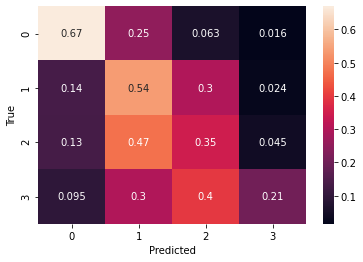

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_df['age_group'], label_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
sn.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()